- PostgreSQL의 타임 라인은 원래 데이터베이스 클러스터와 복구된 데이터베이스 클러스터를 구별하는 데 사용됨.
- PITR의 핵심 개념.
- 이 섹션에서는 타임라인과 관련된 두 가지 항목인 timelineId와 타임라인 기록 파일에 대해 설명.

# **timelineId**

- 각 타임라인 에는 1에서 시작하는 4바이트 부호 없는 정수인 해당 timelineId 가 제공됨.

- 개별 timelineId가 각 데이터베이스 클러스터에 할당됨.
  - initdb 유틸리티로 생성된 원본 데이터베이스 클러스터의 timelineId는 1.
  - 데이터베이스 클러스터가 복구될 때마다 timelineId는 1씩 증가
  - 예를 들어 이전 섹션의 예에서 원본 클러스터에서 복구된 클러스터의 timelineId는 2.

<br>

- 그림은 timelineId 관점에서 PITR 프로세스를 보여줌.

- 먼저, 복구 시작점으로 돌아가기 위해 현재 데이터베이스 클러스터를 제거하고 과거에 생성된 기본 백업을 복원.
- 이 상황은 그림의 빨간색 화살표 곡선으로 표시됨.

- 다음으로 PostgreSQL 서버를 시작
  - 이 서버는 초기 타임라인(timelineId 1)을 따라 추적하여 pg_backup_start 에 의해 생성된 REDO 지점부터 복구 대상까지 아카이브 로그의 WAL 데이터를 재생
  - 이 상황은 그림의 파란색 화살표 선으로 표시됨
  - 그런 다음 새 timelineId 2가 복구된 데이터베이스 클러스터에 할당되고 PostgreSQL이 새 타임라인에서 실행됨.



**Relation of timelineId between an original and a recovered database clusters.**

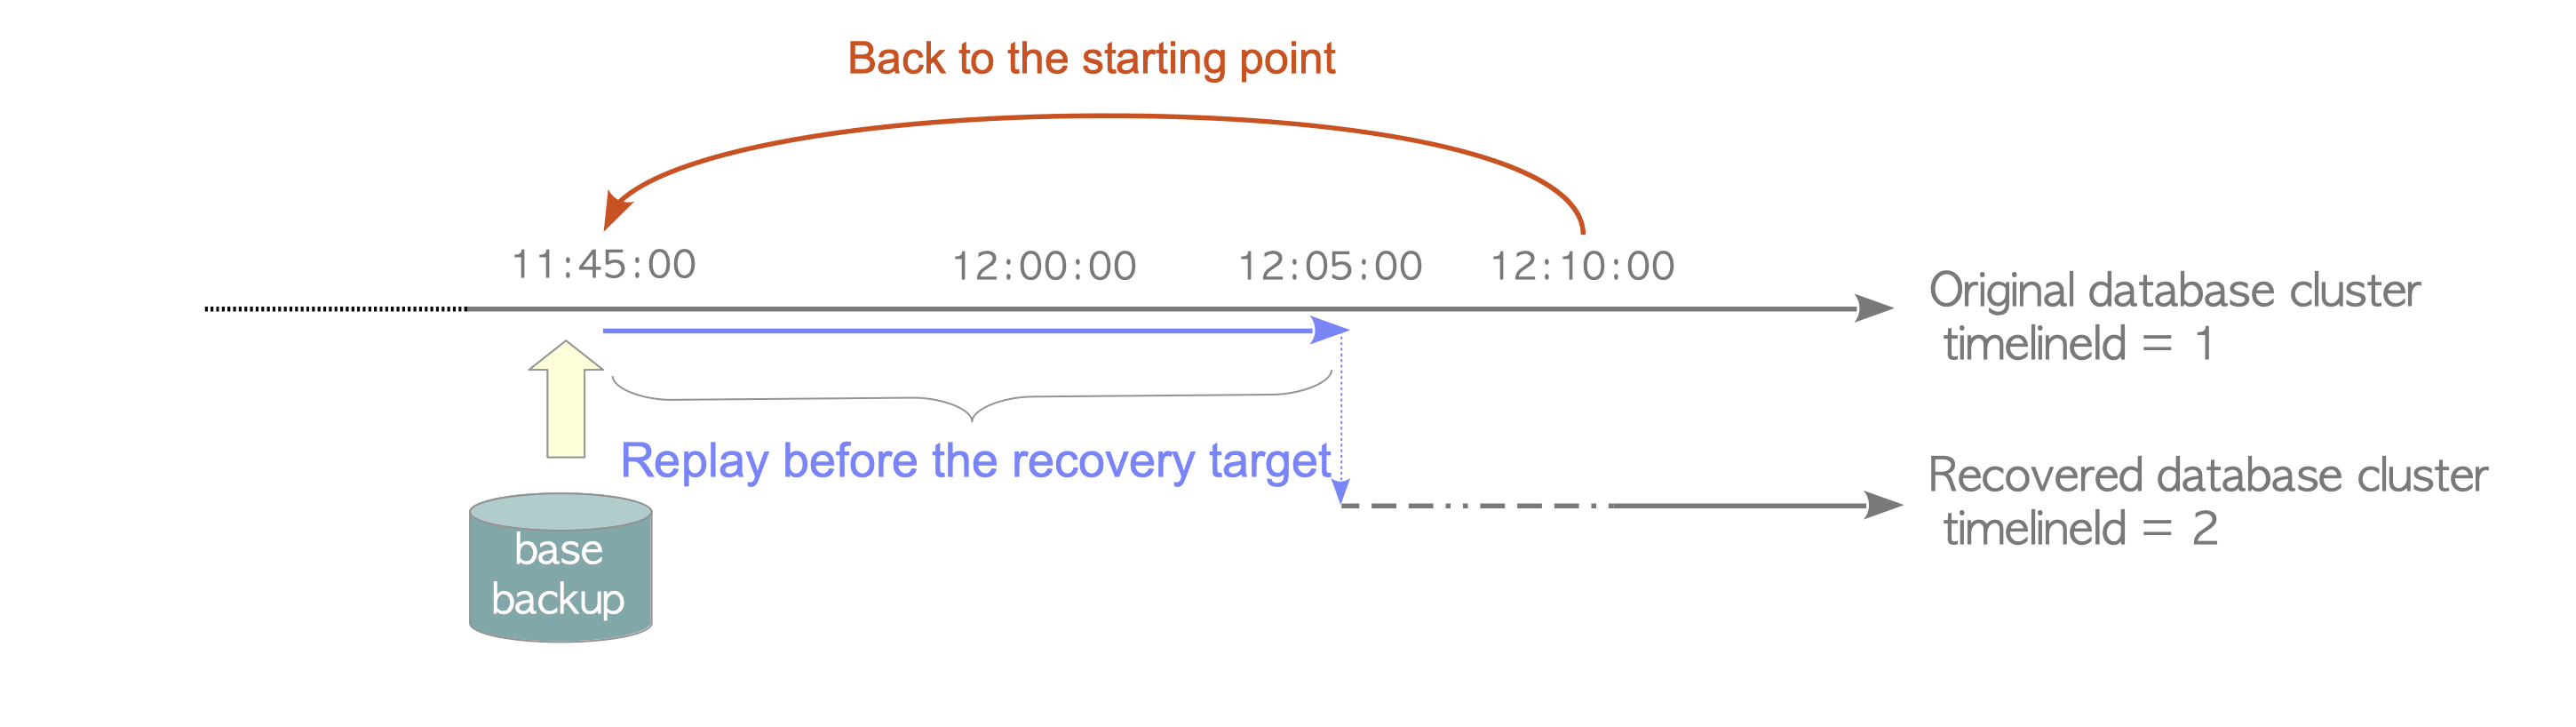

- WAL 세그먼트 파일 이름의 처음 8자리는 세그먼트를 생성한 데이터베이스 클러스터의 timelineId와 동일
  - timelineId가 변경되면 WAL 세그먼트 파일 이름도 변경됨.

- WAL 세그먼트 파일을 중심으로 복구 프로세스를 다시 설명할 수 있음.
  - 두 개의 아카이브 로그 ' 00000001 0000000000000009'와 ' 00000001 000000000000000A' 를 사용하여 데이터베이스 클러스터를 복구한다고 가정
  - 새로 복구된 데이터베이스 클러스터에는 timelineId 2가 할당되고 PostgreSQL은 ' 00000002 000000000000000A'에서 WAL 세그먼트를 생성.

**Relation of WAL segment files between an original and a recovered database clusters.**

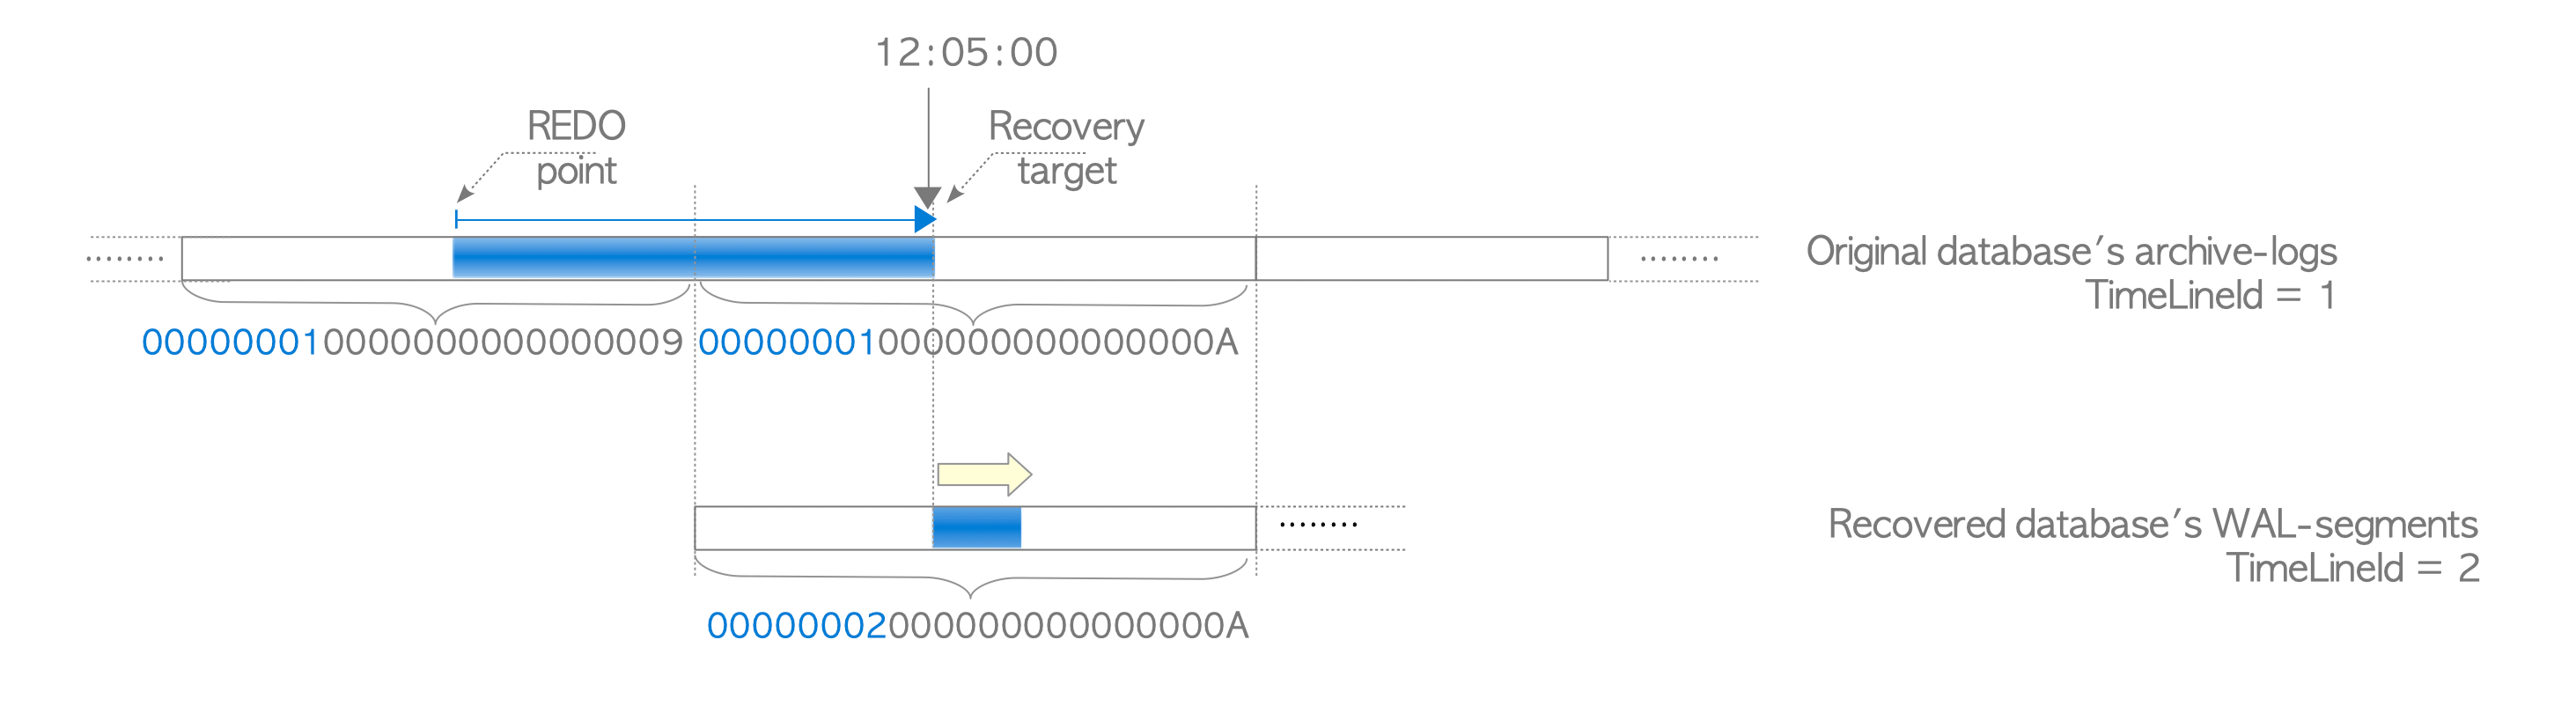

# **Timeline History File**

- PITR 프로세스가 완료되면 archive 디렉터리와 pg_xlog 하위 디렉터리(버전 10 이상에서는 pg_wal 하위 디렉터리)에 '00000002.history'와 같은 이름의 타임라인 히스토리 파일이 생성됨.
  - 이 파일은 어느 타임라인에서 언제 분기되었는지 기록.


**이 파일의 명명 규칙**


```
"8-digit new timelineId".history
```

- 타임라인 히스토리 파일에는 최소 한 라인이 포함되며, 각 라인은 다음 세 가지 항목으로 구성됨.
  - timelineId - 복구에 사용되는 아카이브 로그의 timelineId.
  - LSN - WAL 세그먼트 전환이 발생한 LSN 위치.
  - reason - 타임라인이 변경된 이유에 대한 사람이 읽을 수 있는 설명.

<br>

- 구체적인 예


```
postgres> cat /home/postgres/archivelogs/00000002.history
1	  0/A000198	before 2024-1-1 12:05:00.861324+00
```

**다음과 같은 의미:**

> 데이터베이스 클러스터(timelineId = 2)는 timelineId가 1인 기본 백업을 기반으로 하며, ‘0/A000198’까지 보관 로그를 재생하여 ‘2024-1-1 12:05:00.861324+00’ 바로 전 시간으로 복구됨.

- 이러한 방식으로 각 타임라인 기록 파일은 복구된 개별 데이터베이스 클러스터의 전체 기록을 알려
  - 또한 PITR 프로세스 자체에서도 사용됨.

**info**

- 버전 9.3에서는 타임라인 히스토리 파일 형식이 변경됨.
-  버전 9.3 이상 및 이전 버전의 형식은 아래에 표시되어 있지만 자세히 설명되어 있지는 않음.

- 최신 버전 9.3:

```
timelineId	LSN	"reason"
```

- 버전 9.2까지:

```
timelineId	WAL_segment	"reason"
```